In [18]:
from collections import namedtuple

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.collections import PatchCollection

import numpy as np
import random
import time
from IPython import display

from pyDPMP.messagepassing import MaxSumMP, tree_sched
from pyDPMP.mrf import Factor, MRF, calc_potentials
from pyDPMP.particleselection import SelectDiverse, SelectLazyGreedy
from pyDPMP.proposals import random_walk_proposal, mixture_proposal
from pyDPMP.util import merge_dicts, set_seed
from pyDPMP import DPMP_infer

# %config InlineBackend.figure_format = 'svg'

In [19]:
Circle = namedtuple('Circle', ['center', 'radius'])

def circle_dist(circ, x):
    y = circ.center - x
    return np.sqrt(np.dot(y, y)) - circ.radius

ENVIRONMENT = [Circle(np.array([x, y]), 0.25) for x in range(5) for y in range(5)]

In [20]:
hinge_pot = lambda x_s: min(0, np.sqrt(np.dot(x_s, x_s)) - 1)
log_barrier_pot = lambda x_s: np.log(np.dot(x_s, x_s) - 1) if np.dot(x_s, x_s) > 1 else -np.inf
def huber_pot(x_s, epsilon):
    d = min(circle_dist(c, x_s) for c in ENVIRONMENT)
    if d < 0:
        return d - epsilon / 2.0
    elif (0 <= d) and (d <= epsilon):
        return -1.0 / (2.0 * epsilon) * ((d - epsilon) ** 2)
    else:
        return 0.0

In [27]:
T = 15
x_start = np.array([0.5, 2.5])
x_goal = np.array([3.5, 1.5])

def deriv_pot(w):
    def pot(*args):
        # Reduce the args by taking finite differences until we get down to a single number.
        # Velocity for two args, acceleration for 3, etc.
        xs = list(args)
        while len(xs) > 1:
            xs = [x_s - x_t for (x_s, x_t) in zip(xs[:-1], xs[1:])]
        x = xs[0]
        return -0.5 * np.dot(x, x) * w
    return pot

obstacle_pots = {
    'obs_{}'.format(t): Factor([t], lambda x_t: huber_pot(x_t, 0.1))
    for t in range(T)
}

def motion_pots(deriv, w):
    pot = deriv_pot(w)
    start_pot = {'motion_d{}_start'.format(deriv): Factor(range(deriv), lambda *args: pot(*((x_start,) + args)))}
    inter_pots = {
        'motion_d{}_t{}'.format(deriv, t): Factor(list(t + np.arange(deriv + 1)), pot)
        for t in range(T - deriv)
    }
    goal_pot = {'motion_d{}_goal'.format(deriv): Factor(range(T - deriv, T), lambda *args: pot(*(args + (x_goal,))))}
    return merge_dicts(start_pot, inter_pots, goal_pot)

def velocity_pot_vec(x_s_lst, x_t_lst):
    x_s = np.array(x_s_lst)
    x_t = np.array(x_t_lst)
    d0 = np.power(x_s[:,0].reshape((len(x_s_lst), 1)) - x_t[:,0].reshape((1, len(x_t_lst))), 2)
    d1 = np.power(x_s[:,1].reshape((len(x_s_lst), 1)) - x_t[:,1].reshape((1, len(x_t_lst))), 2)
#     assert np.sqrt(d0 + d1).shape == (len(x_s_lst), len(x_t_lst))
#     raise Exception('hey')
    return -1.0 * (d0 + d1)
    
# mrf = MRF(range(T), merge_dicts(
#     obstacle_pots,
#     motion_pots(1, 1.0)))

mrf = MRF(range(T), merge_dicts(
    obstacle_pots,
    {'motion_d1_start': Factor([0], None, lambda x_0: velocity_pot_vec([x_start], x_0).ravel())},
    {'motion_d1_t{}'.format(t): Factor([t, t + 1], None, velocity_pot_vec) for t in range(T - 1)},
    {'motion_d1_goal': Factor([T - 1], None, lambda x_T: velocity_pot_vec(x_T, [x_goal]).ravel())}))

In [28]:
maxsum = MaxSumMP(mrf, sched=tree_sched(mrf, 0))

In [29]:
def uniform_proposal(mrf, nAdd, x):
    return {v: np.random.rand(nAdd[v], 2) * 7.0 - 1.5 for v in mrf.nodes}

def midpoint_proposal(mrf, nAdd, x):
    x_prop = {t: [] for t in range(T)}
    for t in range(1, T - 1):
        x_prop[t] = [0.5 * (random.choice(x[t - 1]) + random.choice(x[t + 1]))
                     for _ in range(nAdd[t])]
    return x_prop

def flip_proposal(mrf, nAdd, x):
    return {t: [random.choice(x[t]) * np.array([-1, 1]) for _ in range(nAdd[t])]
            for t in range(T)}

In [30]:
x0 = {t: [(1 - float(t)/T) * x_start + (float(t)/T) * x_goal] for t in mrf.nodes}
# x0 = {t: [(1 - float(t)/T) * x_start + (float(t)/T) * x_goal + np.array([1,0])] for t in mrf.nodes}

In [31]:
nParticles = 50

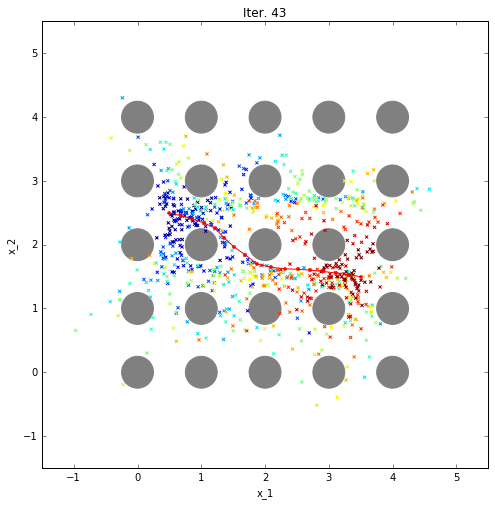

('Iter', 44)
    ... Proposing new particles
    ... Proposing new particles 0.0811991691589
    ... Calculating potentials and MAP
        ... potentials


KeyboardInterrupt: 

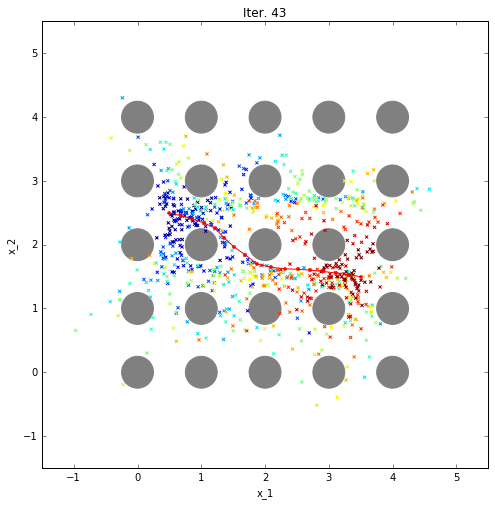

In [33]:
%matplotlib inline

set_seed(1)

plt.figure(figsize=(8, 8))
def callback(info):
    x = info['x']
    xMAP = info['xMAP']

    plt.clf()
    plt.axis([-1.5, 5.5, -1.5, 5.5])

    # Plot circles
    an = np.linspace(0, 2 * np.pi, 100)
    plt.gca().add_collection(PatchCollection(
        [mpatches.Circle(c.center, c.radius)
         for c in ENVIRONMENT], color='grey'))

    particles = [x_t for t in range(T) for x_t in x[t]]
    c = [float(t) / float(T) for t in range(T) for x_t in x[t]]
#     plt.scatter(*zip(*particles), s=10, c='r', marker='x')
    plt.scatter(*zip(*particles), s=10, c=c, marker='x')

    MAPparticles = [x_start] + [xMAP[t] for t in range(T)] + [x_goal]
    plt.plot(*zip(*MAPparticles), c='r', marker='.')

    plt.xlabel('x_1')
    plt.ylabel('x_2')
    plt.title('Iter. %d' % info['iter'])

    display.clear_output(wait=True)
    display.display(plt.gcf())
#     time.sleep(0.25)

xMAP, xParticles, stats = DPMP_infer(mrf,
                                     x0,
                                     nParticles,
                                     mixture_proposal([uniform_proposal,
                                                       random_walk_proposal(1e-2 * np.eye(2)),
                                                       random_walk_proposal(1 * np.eye(2))],
                                                      weights=[0.25, 0.75, 0.0]),
                                     SelectLazyGreedy(),
                                     maxsum,
                                     conv_tol=None,
                                     max_iters=100,
                                     callback=callback,
                                     verbose=True)

display.clear_output(wait=True)

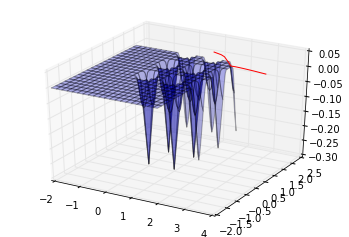

In [127]:
%matplotlib qt
from mpl_toolkits.mplot3d import axes3d
from matplotlib import cm

fig = plt.figure(1)
ax = fig.gca(projection='3d')
X, Y, Z = axes3d.get_test_data(0.05)

X = np.arange(-2, 2, 0.05)
Y = np.arange(-2, 2, 0.05)
x_mesh, y_mesh = np.meshgrid(X, Y)
Z = np.array([[huber_pot([x, y], 0.1) for x in X] for y in Y])
ax.plot_surface(x_mesh, y_mesh, Z, rstride=4, cstride=4, alpha=0.3)

x_path, y_path = zip(*[xMAP[t] for t in range(T)])
z_path = [huber_pot(xMAP[t], 0.1) for t in range(T)]
ax.plot(x_path, y_path, z_path, c='r')

In [12]:
%matplotlib qt

import matplotlib.animation as animation

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, autoscale_on=False, xlim=(-2.5, 2.5), ylim=(-2.5, 2.5))
ax.grid()

an = np.linspace(0, 2*np.pi, 100)
plt.plot(np.cos(an), np.sin(an))

line, = ax.plot([], [], 'o-', lw=2)

def anim_init():
    line.set_data([], [])
    return (line,)

def animate(i):
    x, y = xMAP[i][0], xMAP[i][1]

    line.set_data([x], [y])
    return (line,)

ani = animation.FuncAnimation(fig, animate, range(T),
    interval=25, blit=False, init_func=anim_init)

ani.save('basic_plan.mp4', fps=25)